In [122]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from IPython.display import clear_output
import random

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [21]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
# Trabajo en Google Colab
with open('/content/dfs.pkl', 'rb') as archivo:
    dfs = pickle.load(archivo)

In [3]:
len(dfs)

28

In [4]:
dfs[0].shape, dfs[0]

((347, 16),
 array([[0.7915103647248436, 0.2555500694510472, 0.7699380974337213, ...,
         False, False, False],
        [0.7865745330835447, 0.25505673403305545, 0.7747280572181771, ...,
         False, False, False],
        [0.783257652522349, 0.2498766661455021, 0.7779860729045281, ...,
         False, False, False],
        ...,
        [0.6364856902165876, 0.4375924946410434, 0.6253294989385919, ...,
         False, False, False],
        [0.6408687134853148, 0.49037984435256066, 0.6271023396941757, ...,
         False, False, False],
        [0.6467127411407548, 0.5022200093809627, 0.6308854307720998, ...,
         False, False, False]], dtype=object))

Vamos a predecir 6*12 valores, es decir 2h adelante, y vamos a tomar como base el doble de valores, es decir 12h.

In [101]:
n_steps_in = 6*12
n_steps_out = 6*12
print(n_steps_in, n_steps_out)

72 72


In [102]:
# Dividir en subsecuencias
def split_sequences(sequences, n_steps_in, n_steps_out):
  X = list()
  y = list()
  for split in sequences:
    for i in range(0, len(split), n_steps_out):
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out-1
      if out_end_ix > len(split):
        break
      else:
        seq_x = split[i:end_ix]
        seq_y = split[end_ix-1:out_end_ix, 0] # battery
      X.append(seq_x)
      y.append(seq_y)
  return np.asarray(X).astype('float32'), np.asarray(y).astype('float32')

In [103]:
# Crear datasets de entrenamiento y test
X, y = split_sequences(dfs, n_steps_in, n_steps_out)

seed = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.66, shuffle=True, random_state=seed) # 0.2 validation y 0.1 test

n_features = X.shape[2]

In [104]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((927, 72, 16), (927, 72), (135, 72, 16), (135, 72), (263, 72, 16), (263, 72))

In [105]:
X_train[0][0]

array([0.6437907 , 0.48815984, 0.44474825, 0.66096205, 0.        ,
       0.8947497 , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ], dtype=float32)

In [114]:
class PlotLearning(Callback):
    """
    Callback para plotear las métricas durante el entrenamiento.
    """
    def __init__(self, showLR=False):
      self.showLR = showLR                   # podemos elegir si mostrar o no el plot del learning rate en cada epoch

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []


    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        metric = [x for x in logs if ('val' not in x) and ('lr' not in x)]
        if self.showLR:
          metric.append('lr')

        f, axs = plt.subplots(1,len(metric),figsize=(5 + 5*len(metric), 4))
        clear_output(wait=True)
        for i,ax in enumerate(axs):
          ax.plot(range(1, epoch + 2), self.metrics[metric[i]],'o--',label=metric[i])
          try:
            ax.plot(range(1, epoch + 2), self.metrics['val_' + metric[i]], 'o--', label='val_' + metric[i])
          except:
            pass
          ax.set_xlabel('# epochs')
          ax.set_ylabel(metric[i])
          ax.legend()
          ax.grid()

        plt.tight_layout()
        plt.show()

In [33]:
version = 0

In [115]:
# Definir modelo
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(n_steps_out, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_similarity'])


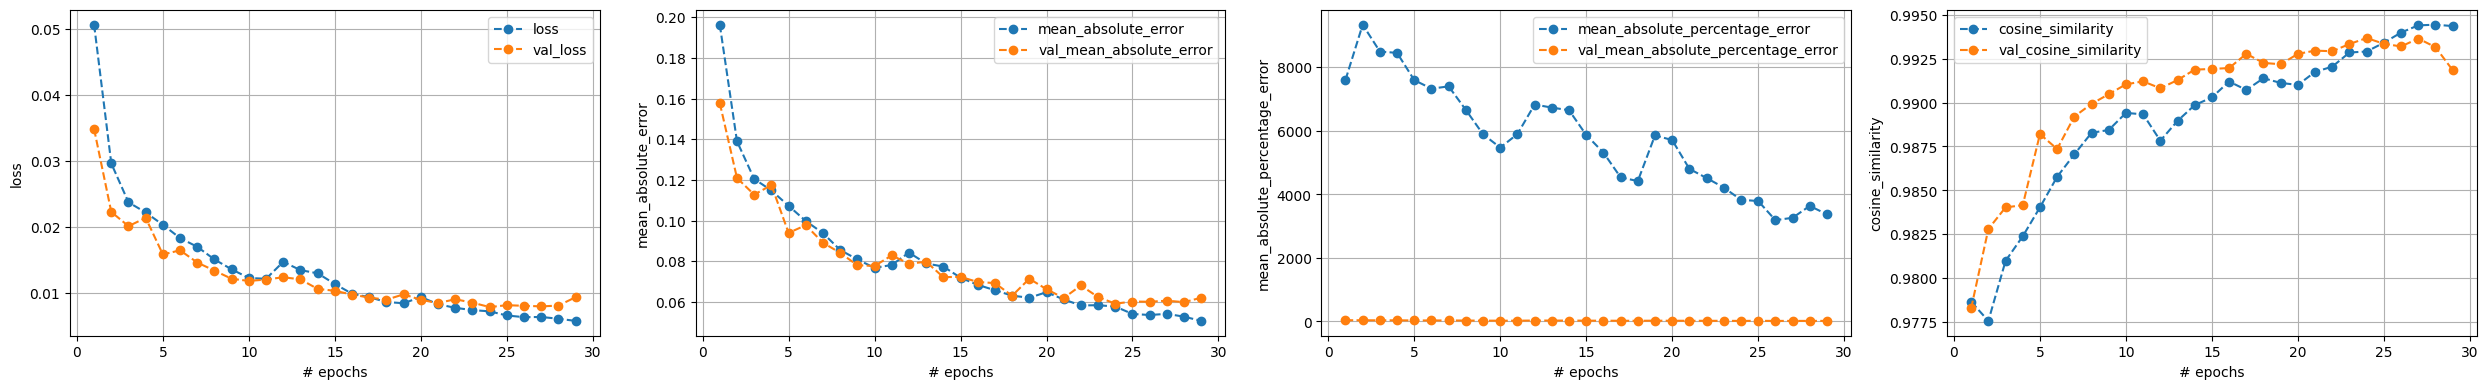

29/29 [==============================] - 9s 323ms/step - loss: 0.0058 - mean_absolute_error: 0.0507 - mean_absolute_percentage_error: 3370.3833 - cosine_similarity: 0.9944 - val_loss: 0.0093 - val_mean_absolute_error: 0.0621 - val_mean_absolute_percentage_error: 19.6249 - val_cosine_similarity: 0.9918


In [116]:
# Entrenar modelo
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[
                       PlotLearning(),
                       EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, restore_best_weights=True)])


In [117]:
# Evaluar modelo
loss, mae, mape, cs = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test MAE:", mae)
print("Test MAPE:", mae)
print("Test Cosine Similarity:", cs)

# Guardamos el modelo
version += 1
model.save(f'/content/lstm-v{version}-{round(loss,3)}.keras')

5/5 [==============================] - 0s 26ms/step - loss: 0.0089 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 13.9818 - cosine_similarity: 0.9914
Test Loss: 0.008853388950228691
Test MAE: 0.06310620158910751
Test MAPE: 0.06310620158910751
Test Cosine Similarity: 0.9914066791534424


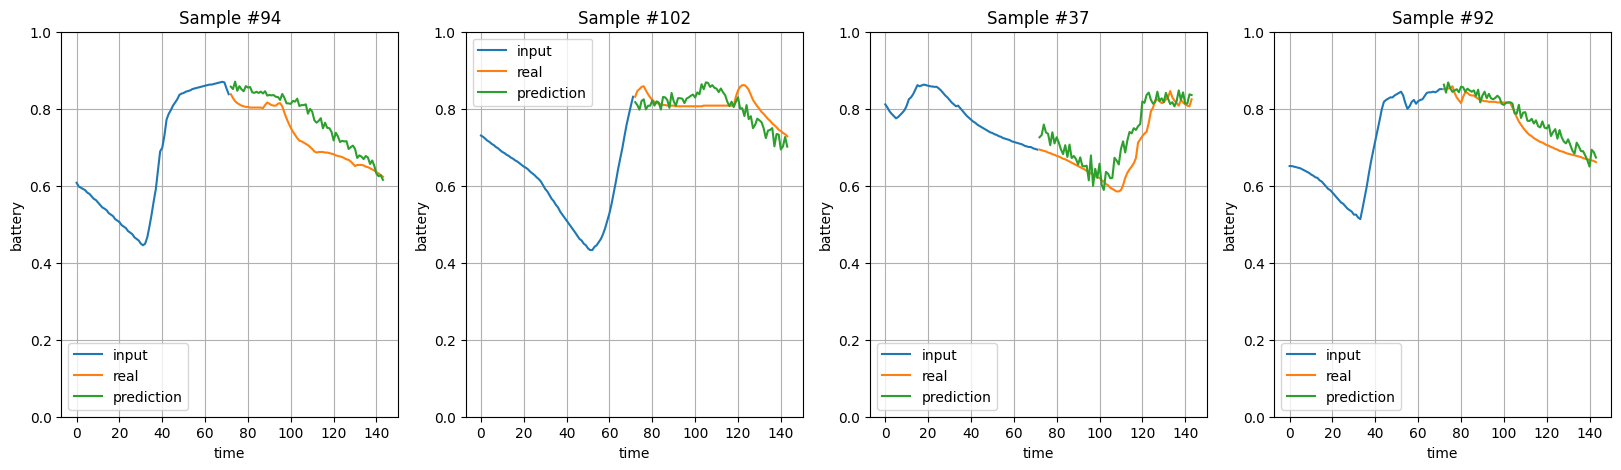

In [135]:
# Predicciones mostradas gráficamente
f, axs = plt.subplots(1,4, figsize=(20, 5))
for w, ax in enumerate(axs):
  item = random.randint(0, len(X_test))
  yhat = model.predict(X_test[item].reshape(1, X_test[item].shape[0], X_test[item].shape[1]), verbose=0)
  ax.plot([i for i in range(n_steps_in)], X_test[item][:, 0], label='input')
  ax.plot([i for i in range(n_steps_in, n_steps_in+n_steps_out)], y_test[item], label='real')
  ax.plot([i for i in range(n_steps_in, n_steps_in+n_steps_out)], yhat[0], label='prediction')
  ax.set_ylim(0, 1)
  ax.set_xlabel('time')
  ax.set_ylabel('battery')
  ax.set_title(f'Sample #{item}')
  ax.legend()
  ax.grid()
plt.show()